![Nuclio logo](https://nuclio.school/wp-content/uploads/2018/12/nucleoDS-newBlack.png)

## 1. Librerias & Google Drive

Para empezar carguemos esas librerias que nos hacen falta

In [ ]:
import tensorflow as tf
from tensorflow import keras as ks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import vgg16
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import time
import datetime
import random
import os

Incorporamos la carpeta de Google Drive para poder "guardar" nuestros modelos

1. Abrir barra lateral de Carpeta
2.  Hacer click en carpeta con logo de Google Drive


In [ ]:
# Aquí iria el codigo para conectarse a Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Preparamos los datos

Cargamos los datos de CIFAR10 de los datasets directamente de las librerias de Keras. Estos ya estan dispuestos en train and test

**Detalle importante:**
> La red neuronal requiere que los inputs sean números reales, y lo haremos forzando la division de los valores de dentro de las matrices 28x28 (que tienen valoress del 0 al 255) por 255.0 (un real)

In [ ]:
cifar10 = ks.datasets.cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train_scaled, x_test_scaled = x_train / 255.0, x_test / 255.0

170498071/170498071 [==============================] - 4s 0us/step


In [ ]:
print("Etiquetas de train:", y_train)


# Convertir los datos en arrays de una dimension (vectores) es una buena mejora en el dataset
y_train = y_train.ravel()
y_test = y_test.ravel()


print("Etiquetas de train (en vector):", y_train)


Etiquetas de train: [[6]
 [9]
 [9]
 ...
 [9]
 [1]
 [1]]
Etiquetas de train (en vector): [6 9 9 ... 9 1 1]


Obtenemos un array con todas las labels de CIFAR10

In [ ]:
cifar10_labels = [
'airplane', # id 0
'automobile',
'bird',
'cat',
'deer',
'dog',
'frog',
'horse',
'ship',
'truck'
]

print('Number of labels: %s' % len(cifar10_labels))

Number of labels: 10


Pintemos una muestra de las imagenes del dataset CIFAR10, a ver si se parece en algo a lo que esperamos.
Primero, vemos que tipos de datos tengo, después mapeamos esas matrices en una escala de grises utilizando el método **.get_cmap()** de PlotLy con los nueve primeros números del dataset.

Train: X=(50000, 32, 32, 3), y=(50000,)
Test: X=(10000, 32, 32, 3), y=(10000,)


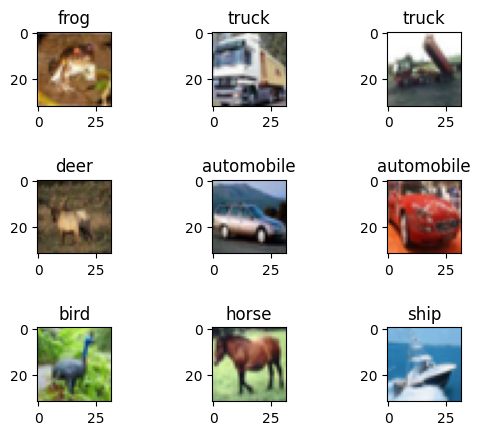

In [ ]:
# Pintemos una muestra de las las imagenes del dataset MNIST

print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))

for i in range(9):

    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
    plt.title(cifar10_labels[y_train[i]])

plt.subplots_adjust(hspace = 1)
plt.show()

Como vamos a querer ir haciendo validación a la vez que entrenamos (muy practico)

In [ ]:
x_val = x_train[-10000:]
y_val = y_train[-10000:]

x_train = x_train[:-10000]
y_train = y_train[:-10000]


Cuando añadimos convoluciones, necesitamos "pre-tratar los datos", porque **la convolución espera una matriz de 4 campos** (más parecido a "imagenes"), en el caso de MNIST. CIFAR10 ya tiene el shape adecuado, así que no tenemos que hacer nada, pero como siempre decimos: es mejor que comprobeis su tamaño.

Por eso, al salir de la Convolution, hay que hacer un Flatten, porque las capas FullDense esperan arrays, no matrices!!

Luego lo imprimimos para ver que todo está correcto

In [ ]:
# Validamos el resultado
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test_scaled.shape, y_test.shape))
print('Validation: X=%s, y=%s' % (x_val.shape, y_val.shape))

Train: X=(40000, 32, 32, 3), y=(40000,)
Test: X=(10000, 32, 32, 3), y=(10000,)
Validation: X=(10000, 32, 32, 3), y=(10000,)


## Arquitectura de la Red Neuronal


In [ ]:
# Creemos una red que será extracción de features basada en VGG16
model_vgg16 = vgg16.VGG16(include_top = False,     # no quiero la salida
                          weights = 'imagenet',
                          input_shape = (32,32,3))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
model_vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [ ]:
# Añadir un Flatten en la última capa
output = model_vgg16.layers[-1].output
output_layer=ks.layers.Flatten()(output)
final_vgg16 = Model(model_vgg16.input,output_layer)
final_vgg16.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [ ]:
# Veamos como va lo de "congelar" capas de entrenamiento
final_vgg16.trainable

True

In [ ]:
# Llevamos las imganes desde su origen al cuello de botella de VGG16, justo después del Flatten()
def llevarACuelloBotella (model, imagenes):
  return model.predict(imagenes)

In [ ]:
x_train_vgg16 = llevarACuelloBotella (final_vgg16, x_train)
x_val_vgg16 = llevarACuelloBotella (final_vgg16, x_val)
x_test_vgg16 = llevarACuelloBotella (final_vgg16, x_test)

313/313 [==============================] - 2s 6ms/step


## Montar la red de clasificación

In [ ]:
output_from_vgg16 = 512

In [ ]:
model_post_vgg = ks.Sequential()

model_post_vgg.add(ks.layers.InputLayer(input_shape=(output_from_vgg16)))
model_post_vgg.add(Dense(512, activation='relu', input_shape=(output_from_vgg16,)))
model_post_vgg.add(BatchNormalization())
model_post_vgg.add(Dense(512, activation='relu'))
model_post_vgg.add(BatchNormalization())
model_post_vgg.add(Dropout(0.3))


model_post_vgg.add(Dense(10, activation='softmax'))
model_post_vgg.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               262656    
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 batch_normalization_1 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                5

## Definir Optimizador

In [ ]:
new_adam = Adam(learning_rate=0.0001)

In [ ]:
model_post_vgg.compile(loss='sparse_categorical_crossentropy', optimizer=new_adam, metrics=['accuracy'])

## Early Stopping

In [ ]:
callback_loss = EarlyStopping(monitor='val_loss', patience=5)
callback_acc = EarlyStopping(monitor='val_acc', patience=5)

## Data Augmentation

## 5. Entrenamiento

Ya podemos ponernos a entrenar el modelo!! Ojo, que hemos de entrenar contra los datos convertidos al formato que espera la Convolution.

Empezaremos con 30 epocs, es decir, 30 pasadas completas del dataset (que a su vez sera con mini-batches internamente), fijando un batch de 64

El metodo .fit() nos permite, definir además si disponemos de varias CPUs, GPUs, y si queremos ir validando datos a cada fin de epoch.

In [ ]:
t = time.perf_counter()

In [ ]:
history = model_post_vgg.fit(x=x_train_vgg16, y=y_train, batch_size=512,     # bajamos el batch_size
                             epochs=100, callbacks=[callback_loss, callback_acc],
                             validation_data=(x_val_vgg16, y_val))

Epoch 1/100
72/79 [==========================>...] - ETA: 0s - loss: 2.1354 - accuracy: 0.3403

79/79 [==============================] - 5s 12ms/step - loss: 2.1039 - accuracy: 0.3488 - val_loss: 1.5656 - val_accuracy: 0.4758
Epoch 2/100
76/79 [===========================>..] - ETA: 0s - loss: 1.5614 - accuracy: 0.4864

79/79 [==============================] - 1s 7ms/step - loss: 1.5587 - accuracy: 0.4869 - val_loss: 1.3713 - val_accuracy: 0.5366
Epoch 3/100
76/79 [===========================>..] - ETA: 0s - loss: 1.4047 - accuracy: 0.5288

79/79 [==============================] - 1s 10ms/step - loss: 1.4043 - accuracy: 0.5286 - val_loss: 1.2920 - val_accuracy: 0.5619
Epoch 4/100
75/79 [===========================>..] - ETA: 0s - loss: 1.3042 - accuracy: 0.5591

79/79 [==============================] - 1s 9ms/step - loss: 1.3044 - accuracy: 0.5595 - val_loss: 1.2480 - val_accuracy: 0.5798
Epoch 5/100
77/79 [============================>.] - ETA: 0s - loss: 1.2310 - accuracy: 0.5798

79/79 [==============================] - 1s 16ms/step - loss: 1.2312 - accuracy: 0.5794 - val_loss: 1.2174 - val_accuracy: 0.5926
Epoch 6/100
77/79 [============================>.] - ETA: 0s - loss: 1.1740 - accuracy: 0.5973

79/79 [==============================] - 1s 15ms/step - loss: 1.1754 - accuracy: 0.5969 - val_loss: 1.1936 - val_accuracy: 0.5994
Epoch 7/100
76/79 [===========================>..] - ETA: 0s - loss: 1.1227 - accuracy: 0.6128

79/79 [==============================] - 1s 15ms/step - loss: 1.1237 - accuracy: 0.6125 - val_loss: 1.1768 - val_accuracy: 0.6061
Epoch 8/100
76/79 [===========================>..] - ETA: 0s - loss: 1.0871 - accuracy: 0.6235

79/79 [==============================] - 1s 7ms/step - loss: 1.0870 - accuracy: 0.6238 - val_loss: 1.1646 - val_accuracy: 0.6087
Epoch 9/100
68/79 [========================>.....] - ETA: 0s - loss: 1.0574 - accuracy: 0.6313

79/79 [==============================] - 0s 6ms/step - loss: 1.0515 - accuracy: 0.6341 - val_loss: 1.1548 - val_accuracy: 0.6090
Epoch 10/100
78/79 [============================>.] - ETA: 0s - loss: 1.0118 - accuracy: 0.6490

79/79 [==============================] - 0s 6ms/step - loss: 1.0117 - accuracy: 0.6490 - val_loss: 1.1451 - val_accuracy: 0.6128
Epoch 11/100
71/79 [=========================>....] - ETA: 0s - loss: 0.9767 - accuracy: 0.6599

79/79 [==============================] - 0s 6ms/step - loss: 0.9806 - accuracy: 0.6581 - val_loss: 1.1389 - val_accuracy: 0.6155
Epoch 12/100
72/79 [==========================>...] - ETA: 0s - loss: 0.9528 - accuracy: 0.6677

79/79 [==============================] - 0s 5ms/step - loss: 0.9519 - accuracy: 0.6671 - val_loss: 1.1322 - val_accuracy: 0.6179
Epoch 13/100
70/79 [=========================>....] - ETA: 0s - loss: 0.9266 - accuracy: 0.6751

79/79 [==============================] - 0s 5ms/step - loss: 0.9269 - accuracy: 0.6750 - val_loss: 1.1291 - val_accuracy: 0.6222
Epoch 14/100
70/79 [=========================>....] - ETA: 0s - loss: 0.9052 - accuracy: 0.6864

79/79 [==============================] - 0s 6ms/step - loss: 0.9049 - accuracy: 0.6854 - val_loss: 1.1248 - val_accuracy: 0.6226
Epoch 15/100
78/79 [============================>.] - ETA: 0s - loss: 0.8753 - accuracy: 0.6941

79/79 [==============================] - 0s 6ms/step - loss: 0.8754 - accuracy: 0.6940 - val_loss: 1.1244 - val_accuracy: 0.6206
Epoch 16/100
68/79 [========================>.....] - ETA: 0s - loss: 0.8551 - accuracy: 0.6991

79/79 [==============================] - 0s 6ms/step - loss: 0.8532 - accuracy: 0.7002 - val_loss: 1.1204 - val_accuracy: 0.6251
Epoch 17/100
78/79 [============================>.] - ETA: 0s - loss: 0.8257 - accuracy: 0.7110

79/79 [==============================] - 0s 6ms/step - loss: 0.8258 - accuracy: 0.7110 - val_loss: 1.1195 - val_accuracy: 0.6247
Epoch 18/100
69/79 [=========================>....] - ETA: 0s - loss: 0.8110 - accuracy: 0.7178

79/79 [==============================] - 0s 5ms/step - loss: 0.8073 - accuracy: 0.7187 - val_loss: 1.1192 - val_accuracy: 0.6245
Epoch 19/100
72/79 [==========================>...] - ETA: 0s - loss: 0.7834 - accuracy: 0.7247

79/79 [==============================] - 0s 5ms/step - loss: 0.7843 - accuracy: 0.7249 - val_loss: 1.1211 - val_accuracy: 0.6234
Epoch 20/100
71/79 [=========================>....] - ETA: 0s - loss: 0.7678 - accuracy: 0.7343

79/79 [==============================] - 0s 6ms/step - loss: 0.7665 - accuracy: 0.7348 - val_loss: 1.1217 - val_accuracy: 0.6237
Epoch 21/100
70/79 [=========================>....] - ETA: 0s - loss: 0.7478 - accuracy: 0.7362

79/79 [==============================] - 0s 5ms/step - loss: 0.7455 - accuracy: 0.7372 - val_loss: 1.1216 - val_accuracy: 0.6262
Epoch 22/100
70/79 [=========================>....] - ETA: 0s - loss: 0.7263 - accuracy: 0.7486

79/79 [==============================] - 0s 5ms/step - loss: 0.7283 - accuracy: 0.7477 - val_loss: 1.1234 - val_accuracy: 0.6270
Epoch 23/100
68/79 [========================>.....] - ETA: 0s - loss: 0.7043 - accuracy: 0.7524

79/79 [==============================] - 0s 6ms/step - loss: 0.7083 - accuracy: 0.7508 - val_loss: 1.1265 - val_accuracy: 0.6258


In [ ]:
elapsed_time = datetime.timedelta(seconds=(time.perf_counter() - t))

print('Tiempo de entrenamiento:', elapsed_time)

Tiempo de entrenamiento: 0:00:18.635639


## 6. Evaluamos los resultados

Obtengamos una grafica de como el error y la accuracy van evolucionando en cada epoch en los datos de entrenamiento y en la validación

In [ ]:
_, acc = model_post_vgg.evaluate(x_test_vgg16, y_test, verbose=0)
print('Modelo con Basic Transfer Learning > %.3f' % (acc * 100.0))

Modelo con Basic Transfer Learning > 62.760


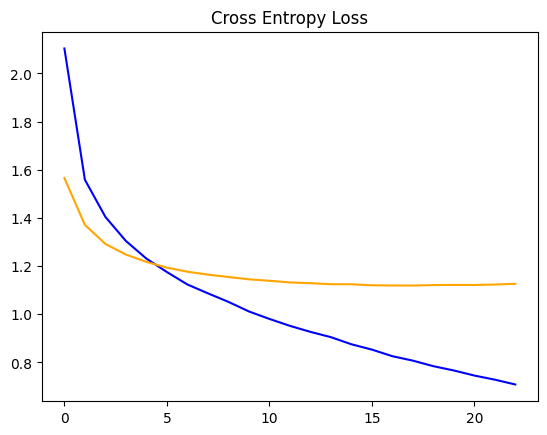

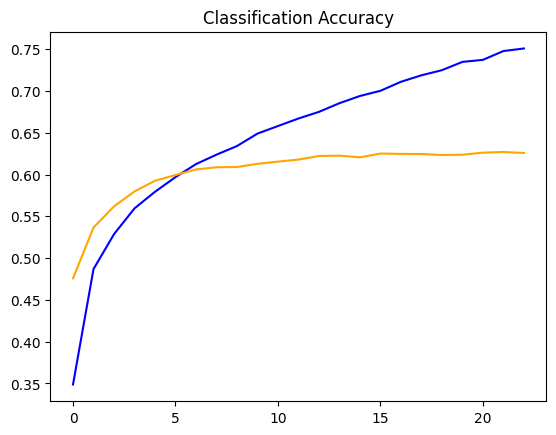

In [ ]:
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='test')
plt.show()

plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='test')
plt.show()

El coste podemos ver que es estable y es en el epoch 15 que se fija en un valor. Además la accuracy baila alrededor de 0.10. No se puede decir que sea un modelo muy bueno.

Veamos que tipo de predicciones estoy obteniendo sobre el conjunto de test (vamos a pintar las imagenes y sus clasificaciones)

In [ ]:
predictions = model_post_vgg.predict(x_test_vgg16)

313/313 [==============================] - 1s 2ms/step


Una de las ventajas de Python es que hay montones de funciones y código realizado por terceras personas. Aquí me he fusilado unas bonitas funciones (que he adaptado un poco a mis necesidades) para poder pintar las imagenes, su label (ground truth) y las clasificaciones que hemos realizado.

In [ ]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

Dibujamos las primeras imagenes, con las predicciones y sus valores reales (un total de 20 imagenes, para no abusar de vuestros laptops)

Coloreamos las prediciones correctas en azul y los fallos en rojo. Aunque primero he impreso las etiquetas para que tengamos una referencia al grafico.

0 airplane
1 automobile
2 bird
3 cat
4 deer
5 dog
6 frog
7 horse
8 ship
9 truck


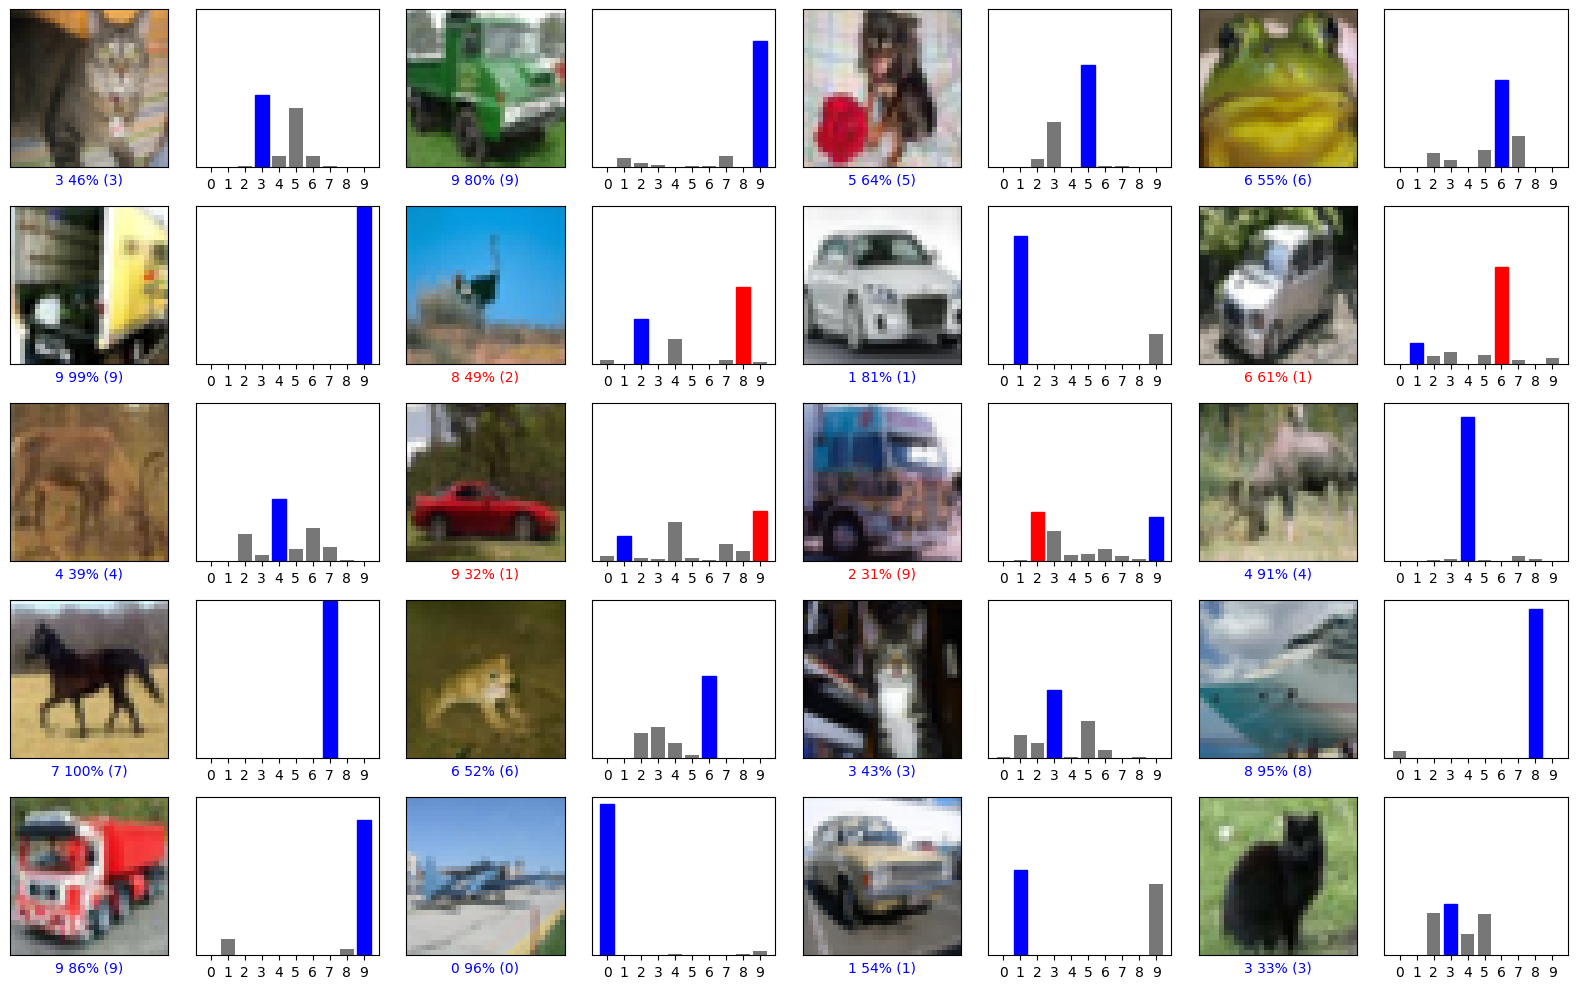

In [ ]:
i = 0
for l in cifar10_labels:
    print(i, l)
    i += 1

num_rows = 5
num_cols = 4
start = 650
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i+start, predictions[i+start], y_test, x_test)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i+start, predictions[i+start], y_test)
plt.tight_layout()
plt.show()

## 7. Guardamos el modelo para futuras evaluaciones

Id cambiando los nombres del archivo para ir guardando los diversos proyectos.
Aquí lo guardamos en "local", pero recordad que lo ideal es que lo guardeis en Google Drive (teneis que montar la unidad, fijar la ruta y allí guardar el modelo .h5)

In [ ]:
ruta_googledrive = "/content/drive/MyDrive/Colab Notebooks/Entregable 4/Modelos (1)"

model.save(ruta_googledrive+'cifar10_1_model.h5')

NameError: name 'model' is not defined